# Eploratory Data Analysis for SPY

In this section of the project we will explore the SPY dataset make a some adjustments and posterior to this we will make use of a Garch model to set the becnhmark for both LSTM and TFT models. In this way we will focus our EDA to find outliers, misbehavements on data and create certain rules when the model cannot handle or work properly based on the market context. Also the idea is to properly preprocess the data so the model can handle the system in a proper manner. The general idea of this system is to create a model capable of forecasting the volatility for the 3 models.

## 🎯 Objective:
Prepare and visualize the data necessary to train three types of volatility forecasting models:

1. **GARCH Benchmark Model** — Univariate model using only log returns.
2. **LSTM Neural Network** — Multivariate model that incorporates technical indicators and historical patterns.
3. **Temporal Fusion Transformer (TFT)** — Sequence-to-sequence forecasting model that requires structured, time-indexed input.

We will use daily OHLCV data from **SPY** (as the asset) and **VIX** (as the implied volatility benchmark).

## 🔍 What this notebook will do:
- Load SPY and VIX historical daily data from Yahoo Finance
- Clean and merge the data
- Compute:
    - Log returns of SPY
    - Rolling realized volatility (5, 10, 20 day)
    - Correlation of VIX vs realized volatility
- Visualize:
    - SPY prices
    - Log returns
    - Realized volatility vs VIX
    - Heatmap of features
- Export three preprocessed datasets:
    - `df_garch` → for GARCH model (log returns only)
    - `df_lstm` → for LSTM (multivariate time series)
    - `df_tft` → for TFT (structured data with time indexing)

This will be the foundation for our modeling phase.

In [1]:
# Getting all the necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Getting both datasets
spy = pd.read_csv('../data/raw/spy_data.csv', parse_dates=['Date'], index_col='Date')
vix = pd.read_csv('../data/raw/vix_data.csv', parse_dates=['Date'], index_col='Date')

In [3]:
spy.head(10)

,Close,High,Low,Open,Volume
Date,,,,,
2012-01-03,100.154587,100.845854,100.099600,100.358825,193697900
2012-01-04,100.311668,100.398077,99.533999,99.918905,127186500
2012-01-05,100.578773,100.728025,99.314082,99.769688,173895000
2012-01-06,100.319557,100.720177,99.989638,100.704463,148050000
2012-01-09,100.563026,100.688701,100.083855,100.547313,99530200
2012-01-10,101.434982,101.843447,101.293581,101.639215,115282000
2012-01-11,101.489998,101.623536,100.955846,101.120800,111540700
2012-01-12,101.733521,101.882772,100.971559,101.780662,118983700
2012-01-13,101.207184,101.372150,100.327398,101.050081,179836200


In [4]:
vix.head(10)

,Close,High,Low,Open,Volume
Date,,,,,
2022-01-03,16.600000,18.540001,16.559999,17.600000,0
2022-01-04,16.910000,17.809999,16.340000,16.570000,0
2022-01-05,19.730000,20.170000,16.580000,17.070000,0
2022-01-06,19.610001,21.059999,19.080000,20.290001,0
2022-01-07,18.760000,20.799999,18.570000,19.850000,0
2022-01-10,19.400000,23.330000,19.290001,19.580000,0
2022-01-11,18.410000,21.000000,18.200001,19.620001,0
2022-01-12,17.620001,18.690001,17.360001,18.170000,0
2022-01-13,20.309999,20.610001,17.450001,18.059999,0


In [5]:
spy = spy.reset_index()
vix = vix.reset_index()

In [6]:
spy.describe()

,Date,Close,High,Low,Open,Volume
count,3425,3425.000000,3425.000000,3425.000000,3425.000000,3.425000e+03
mean,2018-10-23 08:14:00.875912192,285.414624,286.893345,283.691920,285.356286,9.485937e+07
min,2012-01-03 00:00:00,100.154587,100.398077,99.314082,99.769688,2.027000e+07
25%,2015-06-01 00:00:00,171.905807,172.652847,171.038900,171.886229,6.270010e+07
50%,2018-10-22 00:00:00,247.776566,248.898262,246.329365,247.959888,8.313320e+07
75%,2022-03-17 00:00:00,394.931427,397.387401,392.680262,394.980658,1.144972e+08
max,2025-08-15 00:00:00,644.950012,646.190002,642.679993,645.989990,5.072443e+08
std,NaN,140.045702,140.798442,139.150398,140.017687,4.741799e+07


In [7]:
vix.describe()

,Date,Close,High,Low,Open,Volume
count,908,908.000000,908.000000,908.000000,908.000000,908.0
mean,2023-10-24 05:42:33.303964672,19.497698,20.781740,18.735716,19.735793,0.0
min,2022-01-03 00:00:00,11.860000,12.230000,10.620000,11.530000,0.0
25%,2022-11-27 06:00:00,14.827500,15.537500,14.557500,15.020000,0.0
50%,2023-10-23 12:00:00,18.330000,19.480000,17.515000,18.410000,0.0
75%,2024-09-18 06:00:00,22.680000,24.130001,21.807499,23.030001,0.0
max,2025-08-15 00:00:00,52.330002,65.730003,38.580002,60.130001,0.0
std,NaN,5.810726,6.707579,5.270776,5.922205,0.0


### Computing Log Returns

In this part we will compute the log returns of the dataset and take a look on returns spikes and volume spikes on the SPY.

In [8]:
# Calculating log returns
spy['Log_Returns'] = np.log(spy['Close'] / spy['Close'].shift(1))
vix['Log_Returns'] = np.log(vix['Close'] / vix['Close'].shift(1))

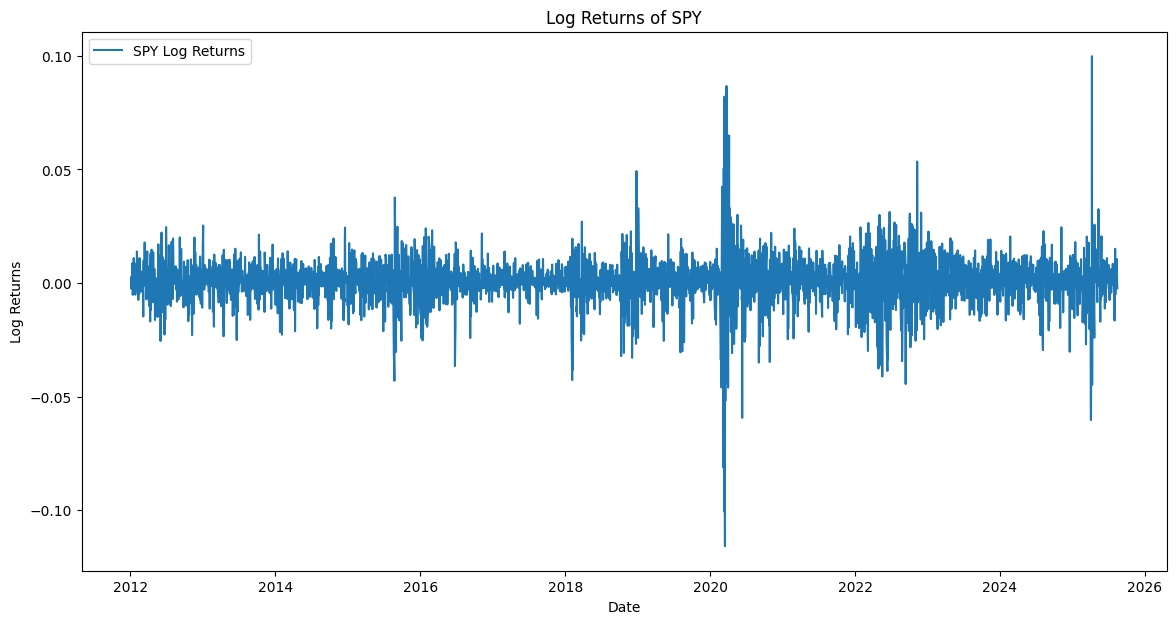

In [11]:
# Plotting the log returns with seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=spy, x='Date', y='Log_Returns', label='SPY Log Returns')
plt.title('Log Returns of SPY')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

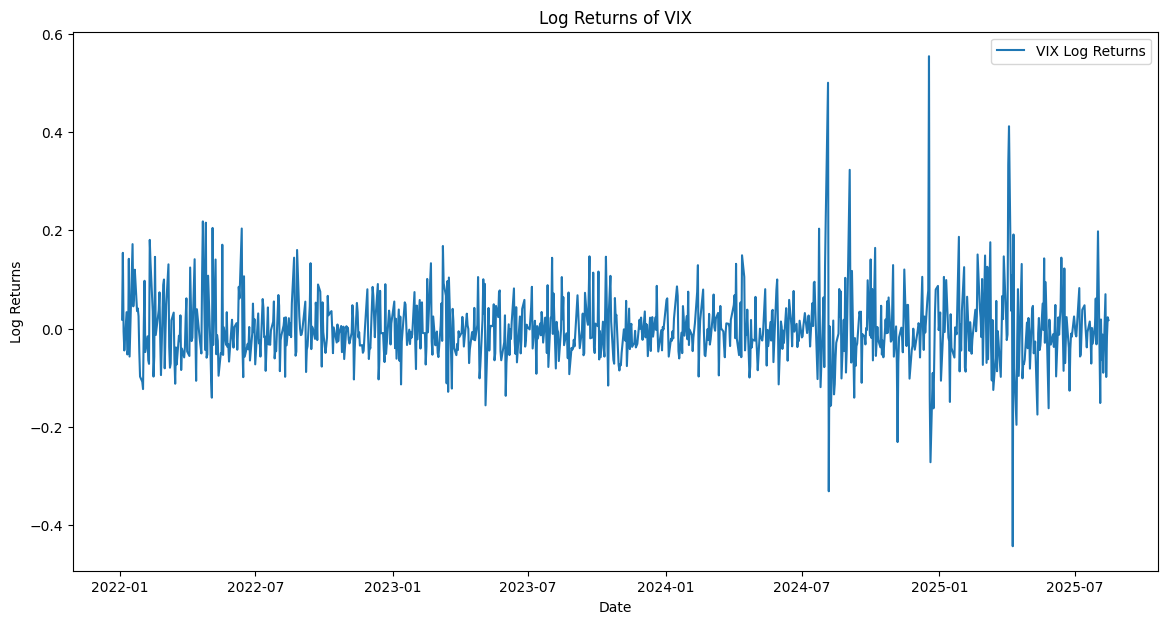

In [12]:
# Plotting the log returns with seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=vix, x='Date', y='Log_Returns', label='VIX Log Returns')
plt.title('Log Returns of VIX')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

In [13]:
# Getting Volatility Spikes
spy['Volatility_Spike'] = spy['Log_Returns'].abs() > 0.05
vix['Volatility_Spike'] = vix['Log_Returns'].abs() > 0.05

In [14]:
# Getting Realized Volatility, with different windows
spy['Realized_Volatility_5'] = spy['Log_Returns'].rolling(window=5).std()
spy['Realized_Volatility_10'] = spy['Log_Returns'].rolling(window=10).std()
spy['Realized_Volatility_20'] = spy['Log_Returns'].rolling(window=20).std()

vix['Realized_Volatility_5'] = vix['Log_Returns'].rolling(window=5).std()
vix['Realized_Volatility_10'] = vix['Log_Returns'].rolling(window=10).std()
vix['Realized_Volatility_20'] = vix['Log_Returns'].rolling(window=20).std()

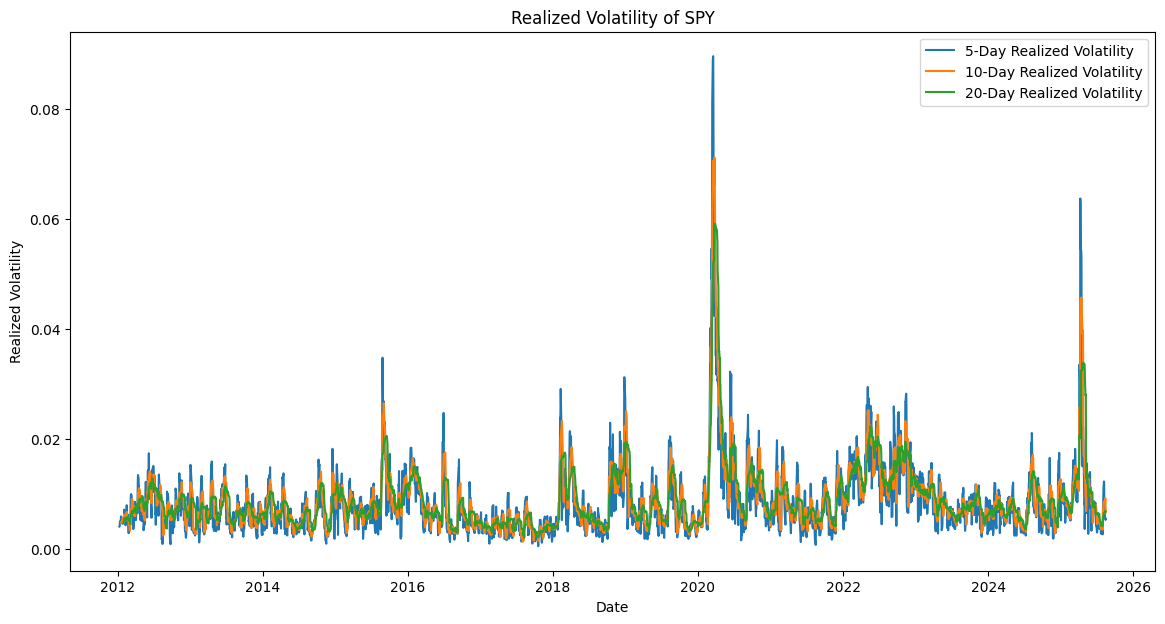

In [15]:
# Looking at the Realized Volatility
plt.figure(figsize=(14, 7))
sns.lineplot(data=spy, x='Date', y='Realized_Volatility_5', label='5-Day Realized Volatility')
sns.lineplot(data=spy, x='Date', y='Realized_Volatility_10', label='10-Day Realized Volatility')
sns.lineplot(data=spy, x='Date', y='Realized_Volatility_20', label='20-Day Realized Volatility')
plt.title('Realized Volatility of SPY')
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.legend()
plt.show()

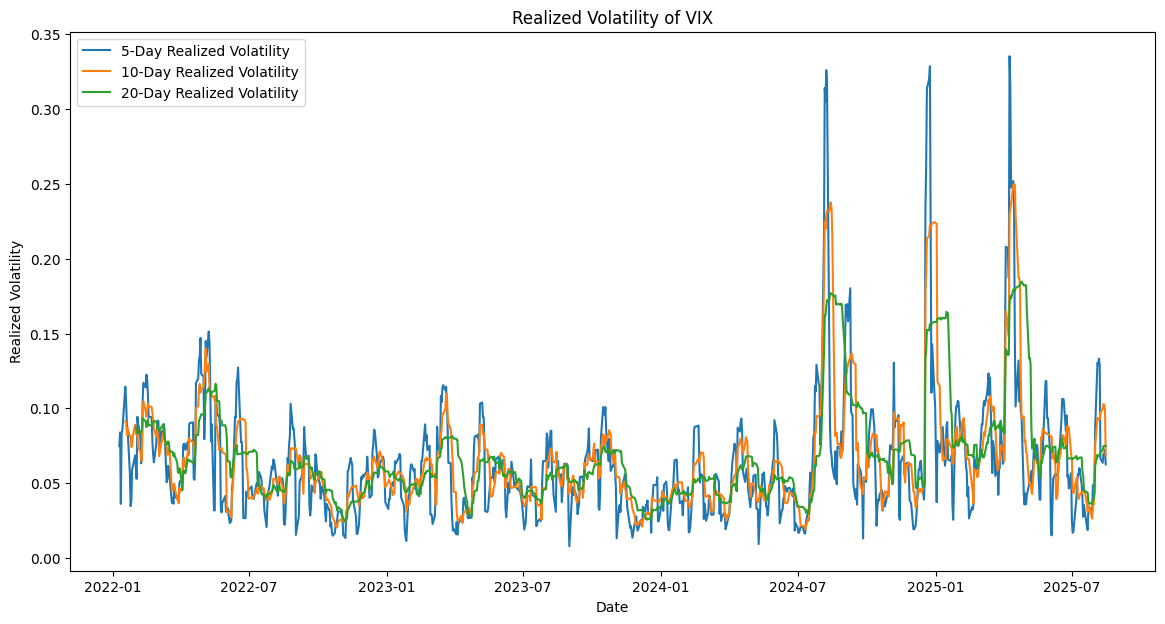

In [16]:
# Looking at the Realized Volatility of VIX
plt.figure(figsize=(14, 7))
sns.lineplot(data=vix, x='Date', y='Realized_Volatility_5', label='5-Day Realized Volatility')
sns.lineplot(data=vix, x='Date', y='Realized_Volatility_10', label='10-Day Realized Volatility')
sns.lineplot(data=vix, x='Date', y='Realized_Volatility_20', label='20-Day Realized Volatility')
plt.title('Realized Volatility of VIX')
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.legend()
plt.show()

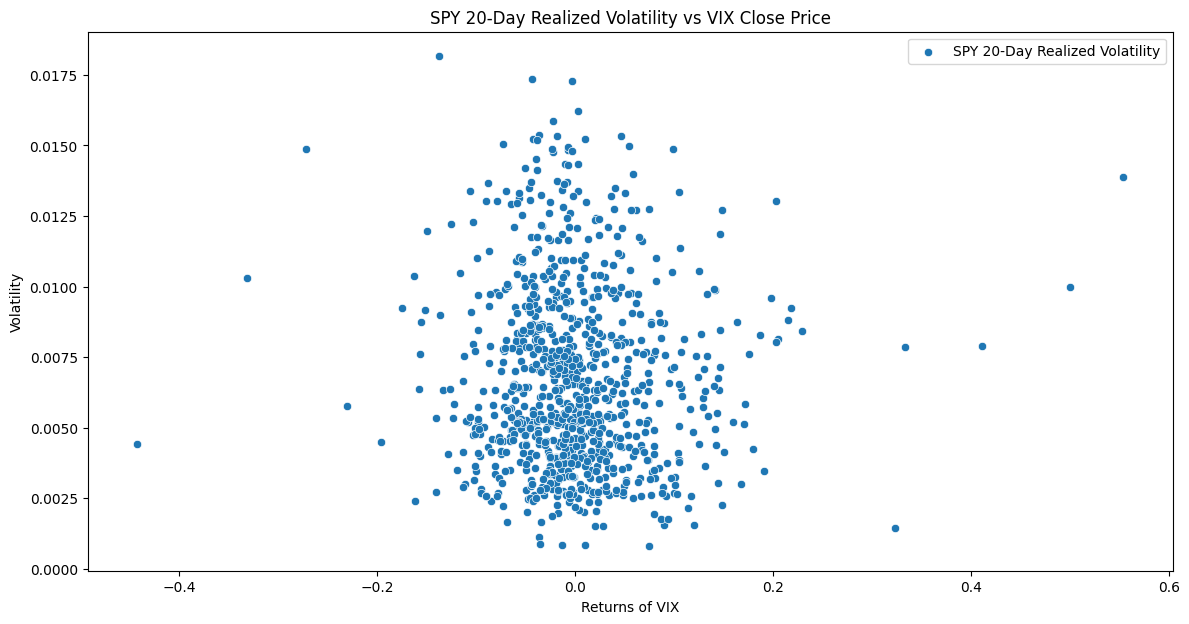

In [ ]:
# Realized Volatility of SPY (X) vs VIX close prices (Y)
plt.figure(figsize=(14, 7))
sns.scatterplot( x=vix['Log_Returns'], y=spy['Realized_Volatility_5'], label='SPY 20-Day Realized Volatility')
plt.xlabel('Returns of VIX')
plt.ylabel('Volatility')
plt.legend()
plt.show()

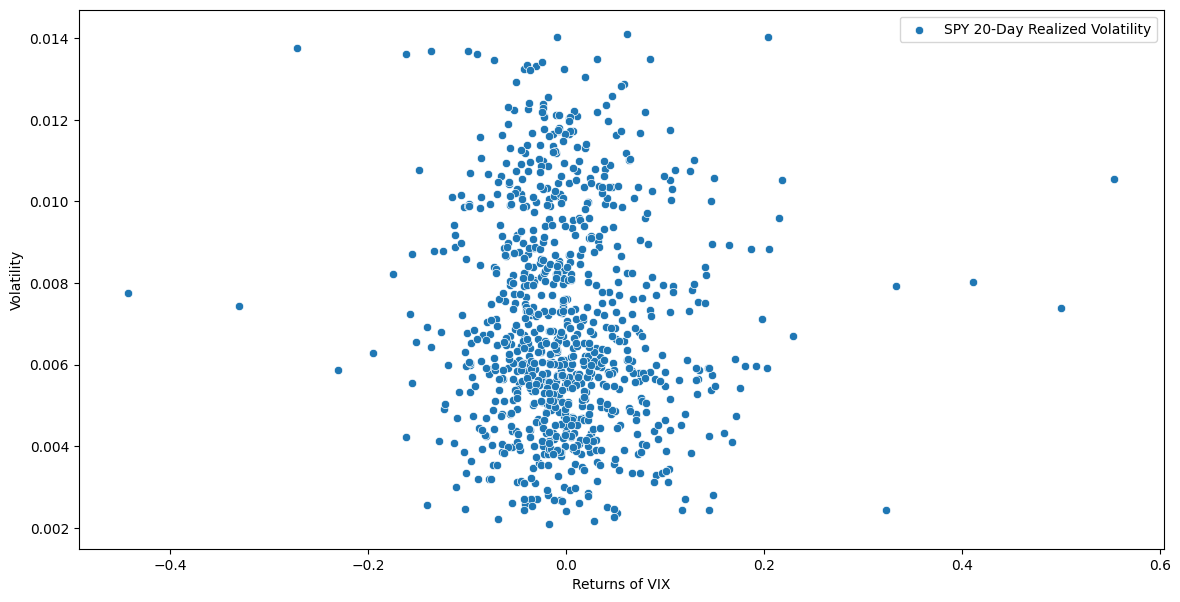

In [23]:
# Realized Volatility of SPY (X) vs VIX close prices (Y)
plt.figure(figsize=(14, 7))
sns.scatterplot( x=vix['Log_Returns'], y=spy['Realized_Volatility_10'], label='SPY 20-Day Realized Volatility')
plt.xlabel('Returns of VIX')
plt.ylabel('Volatility')
plt.legend()
plt.show()

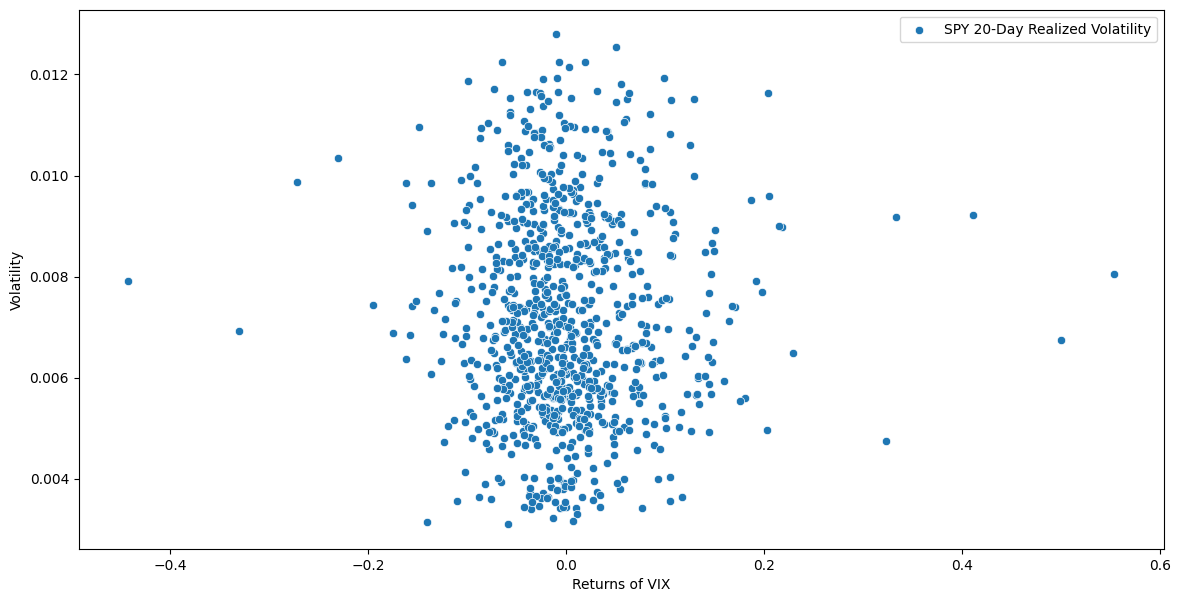

In [24]:
# Realized Volatility of SPY (X) vs VIX close prices (Y)
plt.figure(figsize=(14, 7))
sns.scatterplot( x=vix['Log_Returns'], y=spy['Realized_Volatility_20'], label='SPY 20-Day Realized Volatility')
plt.xlabel('Returns of VIX')
plt.ylabel('Volatility')
plt.legend()
plt.show()

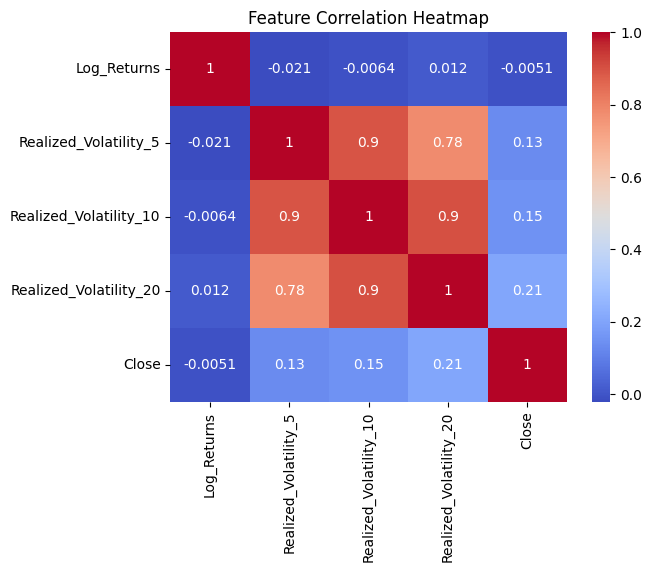

In [32]:
feature_cols = ['Log_Returns', 'Realized_Volatility_5', 'Realized_Volatility_10', 'Realized_Volatility_20']
sns.heatmap(pd.concat([spy[feature_cols], vix['Close']], axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [34]:
# Save the datasets to CSV files
df_garch = spy[['Date',"Log_Returns", "Close"]].dropna().copy().set_index('Date')
df_garch.to_csv('../data/processed/spy_garch.csv')

# For LSTM
df_lstm = spy[['Date', "Close", 'Log_Returns', 'Realized_Volatility_5', 'Realized_Volatility_10', 'Realized_Volatility_20']].dropna().copy().set_index('Date')
df_lstm.to_csv('../data/processed/spy_lstm.csv')

# For Transformer
df_tft = df_lstm.copy()
df_tft['time_idx'] = range(len(df_tft))
df_tft['series_id'] = 'SPY'
df_tft.to_csv('../data/processed/spy_tft.csv')

## This notebook sets up:

- Cleaned merged SPY and VIX data
- Log returns and realized volatility targets
- Basic visualizations and correlation
- Export-ready datasets for GARCH, LSTM, and TFT models

***Next step: Train baseline GARCH model and begin model comparison.***